# Application Programming Interface (API)
- Amber Kutscher
- Data Enrichment

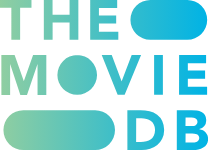

Data Source: https://datasets.imdbws.com

## Data Dictionary

**title.akas.tsv.gz**
- titleId (string) - a tconst, an alphanumeric unique identifier of the title
- ordering (integer) – a number to uniquely identify rows for a given titleId
- title (string) – the localized title
- region (string) - the region for this version of the title
- language (string) - the language of the title
- types (array) - Enumerated set of attributes for this alternative title. One or more of the following: "alternative", "dvd", "festival", "tv", "video", "working", "original", "imdbDisplay". New values may be added in the future without warning
- attributes (array) - Additional terms to describe this alternative title, not enumerated
- isOriginalTitle (boolean) – 0: not original title; 1: original title

**title.basics.tsv.gz**
- tconst (string) - alphanumeric unique identifier of the title
- titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
- primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
- originalTitle (string) - original title, in the original language
- isAdult (boolean) - 0: non-adult title; 1: adult title
- startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
- endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
- runtimeMinutes – primary runtime of the title, in minutes
- genres (string array) – includes up to three genres associated with the title

**title.ratings.tsv.gz**
- tconst (string) - alphanumeric unique identifier of the title
- averageRating – weighted average of all the individual user ratings
- numVotes - number of votes the title has received

In [28]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
pymysql.install_as_MySQLdb()
from urllib.parse import quote_plus as urlquote

# Additional Imports
import os, json, math, time, gzip, csv
from yelpapi import YelpAPI
from tqdm.notebook import tqdm_notebook
import tmdbsimple as tmdb

In [29]:
with open (r"\Users\amber\.secret\tmdb_api.json") as f:
    login = json.load(f)

# Display the keys of the loaded dict
login.keys()

dict_keys(['API Key'])

In [30]:
import tmdbsimple as tmdb
tmdb.API_KEY =  login['API Key']

In [31]:
# Make a movie object using the .Movies function from tmdb
movie = tmdb.Movies(603)

In [32]:
# Movie objects have a .info dictionary
info = movie.info()
info

{'adult': False,
 'backdrop_path': '/oMsxZEvz9a708d49b6UdZK1KAo5.jpg',
 'belongs_to_collection': {'id': 2344,
  'name': 'The Matrix Collection',
  'poster_path': '/bV9qTVHTVf0gkW0j7p7M0ILD4pG.jpg',
  'backdrop_path': '/bRm2DEgUiYciDw3myHuYFInD7la.jpg'},
 'budget': 63000000,
 'genres': [{'id': 28, 'name': 'Action'},
  {'id': 878, 'name': 'Science Fiction'}],
 'homepage': 'http://www.warnerbros.com/matrix',
 'id': 603,
 'imdb_id': 'tt0133093',
 'original_language': 'en',
 'original_title': 'The Matrix',
 'overview': 'Set in the 22nd century, The Matrix tells the story of a computer hacker who joins a group of underground insurgents fighting the vast and powerful computers who now rule the earth.',
 'popularity': 82.417,
 'poster_path': '/f89U3ADr1oiB1s9GkdPOEpXUk5H.jpg',
 'production_companies': [{'id': 79,
   'logo_path': '/tpFpsqbleCzEE2p5EgvUq6ozfCA.png',
   'name': 'Village Roadshow Pictures',
   'origin_country': 'US'},
  {'id': 372,
   'logo_path': None,
   'name': 'Groucho II Film

In [33]:
info['budget']

63000000

In [34]:
info['revenue']

463517383

In [35]:
info['imdb_id']

'tt0133093'

In [36]:
movie = tmdb.Movies('tt1361336')
info = movie.info()
info['budget']

50000000

In [37]:
# Example from package README
# Source = https://github.com/celiao/tmdbsimple
releases = movie.releases()
for c in releases['countries']:
    if c['iso_3166_1'] == 'US':
        print(c['certification'])

PG
PG
PG


In [38]:
# Get the movie object for the current id
movie = tmdb.Movies('tt1361336')
# Save the .info .releases dictionaries
info = movie.info()
releases = movie.releases()
# Loop through countries in releases
for c in releases['countries']:
    # If the country abbreviation==US
    if c['iso_3166_1'] == 'US':
        # Save a "certification" key in the info dict with the certification
        info['certification'] = c['certification']

In [39]:
def get_movie_with_rating(movie_id):
    """Adapted from source = https://github.com/celiao/tmdbsimple"""
    # Get the movie object for the current id
    movie = tmdb.Movies(movie_id)
    # Save the .info .releases dictionaries
    info = movie.info()
    releases = movie.releases()
    # Loop through countries in releases
    for c in releases['countries']:
        # If the country abbreviation==US
        if c['iso_3166_1'] == 'US':
            # Save a "certification" key in info with the certification
            info['certification'] = c['certification']
    return info

In [40]:
test = get_movie_with_rating("tt0848228")
test

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 97.857,
 'poster_path': '/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg',
 'production_companies': [{'id': 420,
   'logo_path'

In [41]:
# Define the folder path where you want to save JSON files
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['.ipynb_checkpoints',
 'final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'title-akas-us-only.csv',
 'title.basics.tsv.gz',
 'title.ratings.tsv.gz',
 'title_basics.csv.gz',
 'title_ratings.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json']

In [42]:
# Process data for each year sequentially
YEARS_TO_GET = [2000, 2001]    

In [43]:
# YEAR = 2000

In [44]:
basics = pd.read_csv('Data/title_basics.csv.gz')
basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0035423,movie,Kate & Leopold,Kate & Leopold,0,2001.0,NaN,118,"Comedy,Fantasy,Romance"
1,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El tango del viudo y su espejo deformante,0,2020.0,NaN,70,Drama
2,tt0068865,movie,Lives of Performers,Lives of Performers,0,2016.0,NaN,90,Drama
3,tt0069049,movie,The Other Side of the Wind,The Other Side of the Wind,0,2018.0,NaN,122,Drama
4,tt0088751,movie,The Naked Monster,The Naked Monster,0,2005.0,NaN,100,"Comedy,Horror,Sci-Fi"


In [45]:
def write_json(new_data, filename):
    """Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""
    with open(filename, 'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
            file_data.append(new_data)
        # Sets file's current position at offset
        file.seek(0)
        # COnvert back to json.
        json.dump(file_data, file)

In [46]:
# Start of OUTER loop
for YEAR in tqdm_notebook(YEARS_TO_GET, desc='YEARS', position=0):
    # Defining the JSON file to store results for the year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    # Check if file exists
    file_exists = os.path.isfile(JSON_FILE)

    # If it does not exist: create it
    if file_exists == False:
        # save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id': 0}],f)


    # Saving new year as the current df
    df = basics.loc[basics['startYear'] == YEAR].copy()

    # Saving movie ids to list
    movie_ids = df['tconst'].copy()
    movie_ids

    # Load existing data from json into a dataframe called "previous_df"
    previous_df = pd.read_json(JSON_FILE)
    previous_df

    # Filter out any ids that are already in the JSON_FILE
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df['imdb_id'])]

    #Get index and movie id from list
    # INNER Loop
    for movie_id in tqdm_notebook(movie_ids_to_get,
                                    desc=f'Movies from {YEAR}',
                                    position=1,
                                    leave=True):
        try:
            # Retrieve then data for the movie id
            temp = get_movie_with_rating(movie_id)  
            # Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            # Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
        # If it fails, make a dict with just the id and Name for certification.
        except Exception as e:
            continue

    final_year_df = pd.read_json(JSON_FILE)
    final_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEARS:   0%|          | 0/2 [00:00<?, ?it/s]

Movies from 2000:   0%|          | 0/1272 [00:00<?, ?it/s]

Movies from 2001:   0%|          | 0/1933 [00:00<?, ?it/s]

In [47]:
# Testing our function by looping through a list of ids
test_ids = ["tt0848228", "tt0332280"]
results = []
for movie_id in test_ids:
    try:
        movie_info = get_movie_with_rating(movie_id)
        results.append(movie_info)
    except:
        pass

pd.DataFrame(results)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",https://www.marvel.com/movies/the-avengers,24428,tt0848228,en,The Avengers,...,1518815515,143,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some assembly required.,The Avengers,False,7.71,29163,PG-13
1,False,/qom1SZSENdmHFNZBXbtJAU0WTlC.jpg,None,29000000,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",http://www.newline.com/properties/notebookthe....,11036,tt0332280,en,The Notebook,...,115603229,123,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Behind every great love is a great story.,The Notebook,False,7.88,10628,PG-13
